<a href="https://colab.research.google.com/github/SKYUTS/MachineLearning/blob/main/Copy_of_property_photo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Create a dataset
Define some parameters for the loader:

**batch size**: Number images that used for each iteration of traning

**image_height and Image_width**: size of images

In [2]:
batch_size = 32
img_height = 180
img_width = 180

mount to your google drive and access to shared data in your drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


provide path to the training data

In [4]:
data_dir = "/content/drive/MyDrive/Machine learning UTS/train_small"

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 7010 files belonging to 7 classes.
Using 5608 files for training.


In [6]:
# TODO 1: create validation dataset from the provided data
# Edit the code by replacing the underscore
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7010 files belonging to 7 classes.
Using 1402 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(class_names)

['bathroom-20241003T200838Z-001', 'bedroom-20241003T200910Z-001', 'dining_room-20241003T200916Z-001', 'exterior-20241003T200919Z-001', 'interior-20241003T200922Z-001', 'kitchen', 'living_room']


# Visualize the data
Here are the first nine images from the training dataset:

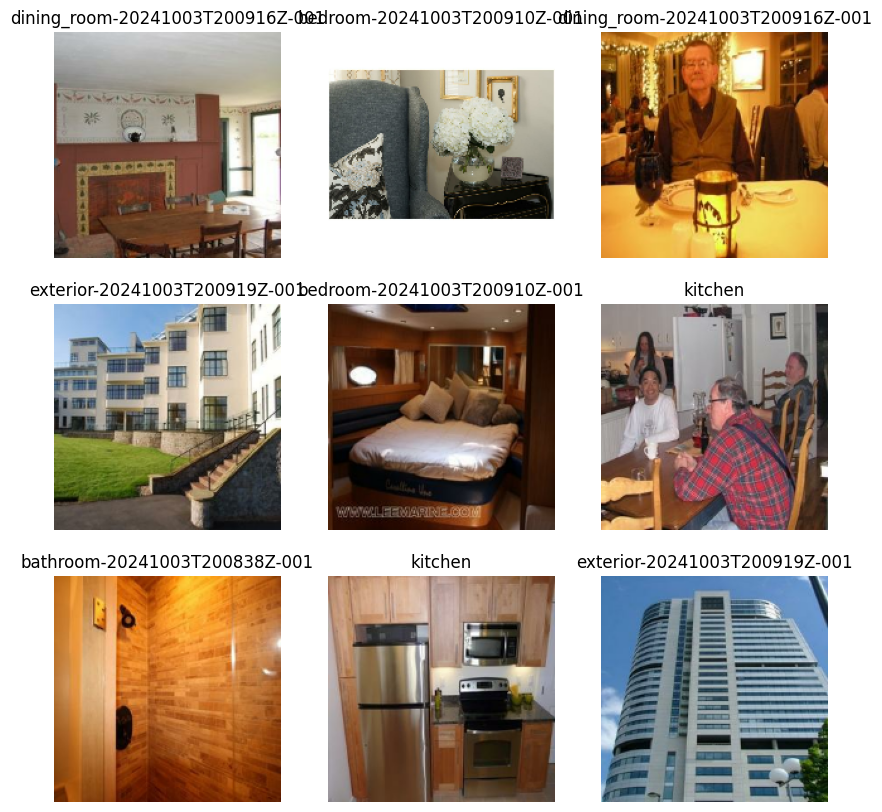

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation, horizontal flipping and random Zoom. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [9]:
# TODO 2: Add a RandomRotation layer with factor=0.2
# Edit the code by replacing the underscore
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(factor=0.2),   #This layer randomly rotates images during training. The factor=0.2 means that the images can be rotated by up to 20% of 360 degrees
  tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

Let's repeatedly apply these layers to the same image and see the result.

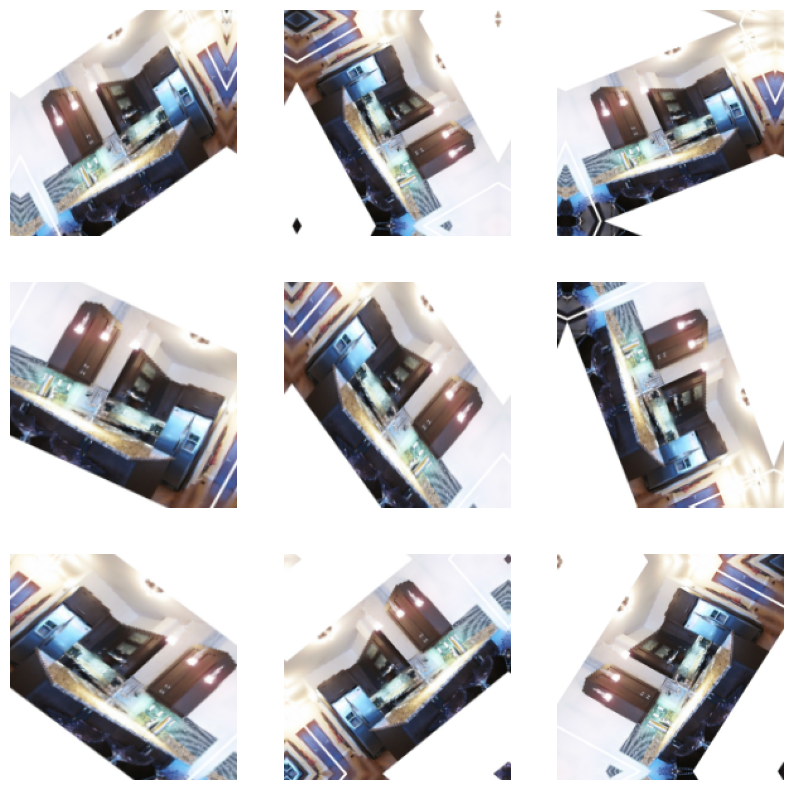

In [10]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

You can add more augmentation layers to get more generalised and then more accurate model

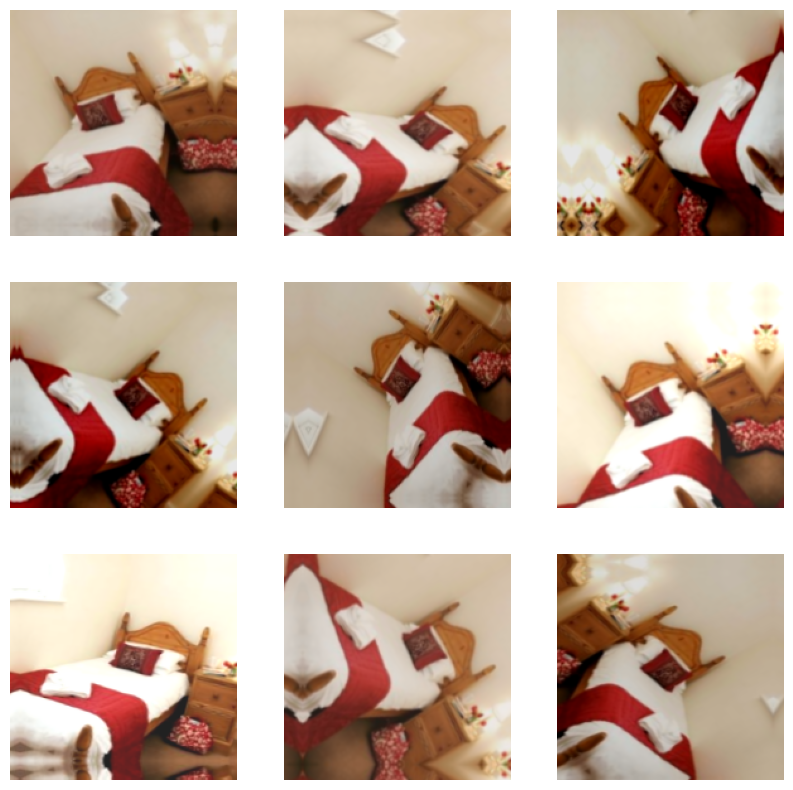

In [11]:
# TODO: Tech Focue Only



data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(factor=0.2),
  tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Existing RandomZoom layer
  tf.keras.layers.RandomContrast(factor=0.2),  # This layer randomly adjusts the contrast of the images. The factor=0.2 means that the contrast can be adjusted by up to 20%.
  tf.keras.layers.RandomBrightness(factor=0.2),  # This layer randomly adjusts the brightness of the images. The factor=0.2 means that the brightness can be adjusted by up to 20%.
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1) # This layer randomly translates (shifts) the images. The height_factor=0.1 and width_factor=0.1 mean that the images can be shifted by up to 10% of their height and width, respectively
])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Add more augmentation layers and see how it improves the model performance.
By adding more augmentation layers,  more variations in the training data, which can help improve the model's robustness and generalization.  

Rescale pixel values
In a moment, you will download tf.keras.applications.InceptionV3 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

Note: We use InceptionV3 because we use it as base model, you need to change it to model you want to use as base model for your project.

In [12]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the base model from the pre-trained convnets
You will create the base model from the **InceptionV3** model. This is pre-trained on the **ImageNet** dataset, a large dataset consisting of 1.4M images and 1000 classes. **ImageNet** is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of **InceptionV3** you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a **InceptionV3** model pre-loaded with weights trained on **ImageNet**. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [13]:
image_size = (img_height, img_width)
image_shape = image_size + (3,)   #This creates a tuple representing the full shape of the input images, including the color channels. The (3,) indicates that the images are in RGB format, with three color channels.
base_model = tf.keras.applications.InceptionV3(
                     include_top=False,
                     weights='imagenet',  #This parameter loads the model with weights pre-trained on the ImageNet dataset. This allows the model to leverage learned features from a large and diverse dataset.
                     input_shape=image_shape #This specifies the shape of the input data that the model will accept. It should match the shape of your input images, including the number of color channels.
                     )

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


If you would like to achieve more performance you may try another base models. the list of model avilable in Keras you can find [here](https://keras.io/api/applications/)

In [14]:
# TODO: Tech Focus only
# Add different base models and compare the model performance

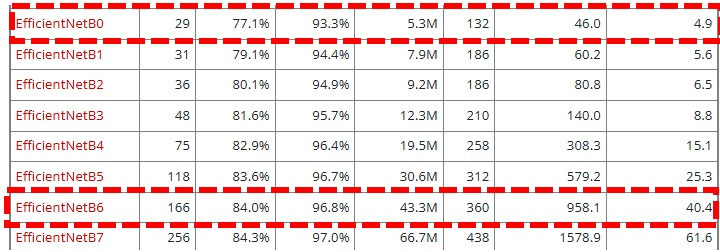





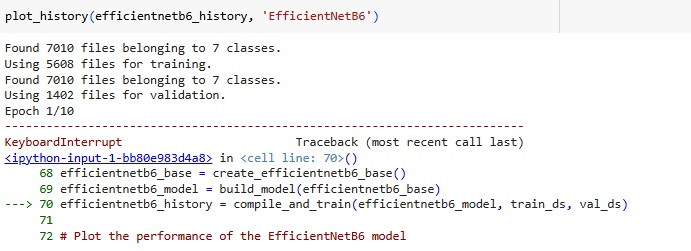

In [15]:
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Define the data directory
# data_dir = "/content/drive/MyDrive/Machine learning UTS/train_small"

# # Define image size and batch size
# img_height = 224  # EfficientNetB0 also uses 224x224 input size
# img_width = 224
# batch_size = 32

# # Define the number of classes
# num_classes = 10  # Replace with the actual number of classes in your dataset

# # Create training and validation datasets
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,  # 20% of data for validation
#     subset="training",
#     seed=123,  # Seed for reproducibility
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# # Preprocess the datasets
# from tensorflow.keras.applications.efficientnet import preprocess_input

# train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
# val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# # Define the EfficientNetB0 base model
# def create_efficientnetb0_base():
#     return tf.keras.applications.EfficientNetB0(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(img_height, img_width, 3)
#     )

# # Build the model
# def build_model(base_model):
#     model = tf.keras.Sequential([
#         base_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(1024, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
#     return model

# # Compile and train the model
# def compile_and_train(model, train_ds, val_ds, epochs=10):
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
#     return history

# # Create and train the EfficientNetB0 model
# efficientnetb0_base = create_efficientnetb0_base()
# efficientnetb0_model = build_model(efficientnetb0_base)
# efficientnetb0_history = compile_and_train(efficientnetb0_model, train_ds, val_ds)

# # Plot the performance of the EfficientNetB0 model
# def plot_history(history, title):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs_range = range(len(acc))

#     plt.figure(figsize=(12, 8))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, acc, label='Training Accuracy')
#     plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#     plt.legend(loc='lower right')
#     plt.title(f'{title} - Training and Validation Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, loss, label='Training Loss')
#     plt.plot(epochs_range, val_loss, label='Validation Loss')
#     plt.legend(loc='upper right')
#     plt.title(f'{title} - Training and Validation Loss')
#     plt.show()

# plot_history(efficientnetb0_history, 'EfficientNetB0')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. InceptionV3 has many layers, so setting the entire model's trainable flag to False will freeze all of them.




In [17]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 89, 89, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 89, 89, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 89, 89, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 87, 87, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 87, 87, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 87, 87, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 87, 87, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 87, 87, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 87, 87, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 43, 43, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 43, 43, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 43, 43, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 43, 43, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 41, 41, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 41, 41, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

## Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


You can potentially add more layers between base layer and prediction layer (bext) here to more fine tune the model and potentially boost the accuracy

In [19]:
# TODO: Tech Focus only
# add more layers and see if it improves the model performance

# Add an intermediate Dense layer with ReLU activation
intermediate_layer_1 = tf.keras.layers.Dense(512, activation='relu')
intermediate_output_1 = intermediate_layer_1(feature_batch_average)

# Add a Dropout layer for regularization
dropout_layer_1 = tf.keras.layers.Dropout(0.5)
dropout_output_1 = dropout_layer_1(intermediate_output_1)

# Add another Dense layer with ReLU activation
intermediate_layer_2 = tf.keras.layers.Dense(256, activation='relu')
intermediate_output_2 = intermediate_layer_2(dropout_output_1)

# Add another Dropout layer
dropout_layer_2 = tf.keras.layers.Dropout(0.5)
dropout_output_2 = dropout_layer_2(intermediate_output_2)

# Final Dense layer for 7-class prediction (logits)
prediction_layer = tf.keras.layers.Dense(7)

# Apply the final Dense layer to the last dropout output
predictions = prediction_layer(dropout_output_2)

# Print the shape of the resulting predictions
print(predictions.shape)


(32, 7)


Apply a tf.keras.layers.Dense layer to convert these features into 7 class prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [20]:
# Add a Dense layer for 7-class prediction
# This layer outputs logits for each class
prediction_layer = tf.keras.layers.Dense(7)

# Apply the Dense layer to the averaged features
predictions = prediction_layer(feature_batch_average)

# Print the shape of the resulting predictions
print(predictions.shape)


(32, 7)


In [21]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


# Build and Compile Model
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.


***Note***: Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


***Note***: if you define more layer in previous steps, you need to add them here to layers of model to be built and compiled.

In [22]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

# TODO 3: Create the model using tf.keras.Model() function
# Edit the code by replacing the underscore
model = tf.keras.Model(inputs=inputs, outputs=outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 4, 4, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,817,127 (83.23 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

# TODO 3: Create the model using tf.keras.Model() function
# Edit the code by replacing the underscore
model = tf.keras.Model(inputs=inputs, outputs=outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

It is interesting to see how the base model without fine tuninng perform: As you can see it very disappointing :-)

In [28]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

44/44 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6860 - loss: 0.8940
initial loss: 0.91
initial accuracy: 0.69


In [33]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6728 - loss: 0.9241
initial loss: 0.91
initial accuracy: 0.69


## Train the Model

Now we can start traning which means fine tuning the base model which is InceptionV3 for now. We start with small number of epoch (10) to see how the final model perofrm.

In [24]:
early = tf.keras.callbacks.EarlyStopping(patience=10,
                                          min_delta=0.01,
                                          restore_best_weights=True)
initial_epochs = 10

# TODO 4: train the model using the model.fit() function
# Edit the code by replacing the underscore

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs,
                    callbacks=[early])

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1054s 6s/step - accuracy: 0.1788 - loss: 2.4311 - val_accuracy: 0.3780 - val_loss: 1.7093
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.3241 - loss: 1.8683 - val_accuracy: 0.5150 - val_loss: 1.3436
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 681s 4s/step - accuracy: 0.4127 - loss: 1.6081 - val_accuracy: 0.5621 - val_loss: 1.2129
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - accuracy: 0.4480 - loss: 1.5492 - val_accuracy: 0.6177 - val_loss: 1.0956
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.4899 - loss: 1.4074 - val_accuracy: 0.6298 - val_loss: 1.0530
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.5021 - loss: 1.3819 - val_accuracy: 0.6498 - val_loss: 1.0097
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.5029 - loss: 1.3708 - val_accuracy: 0.6562 - val_loss: 0.9828
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.5204 - loss: 1.3505 - val_acc

## Learning (Accuracy-Loss) curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the InceptionV3 base model as a fixed feature extractor for transfer learning.

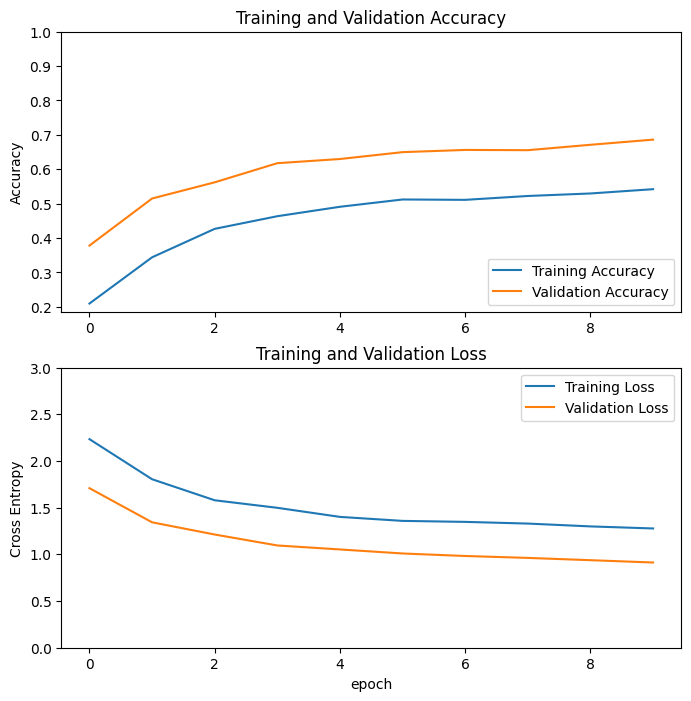

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()